In [9]:
import pymongo
import pandas as pd
import numpy as np
import os
import sys

In [5]:
pwd = %pwd
pwd = os.path.join(pwd, 'dados')

In [6]:
sys.path.insert(0, pwd)

In [7]:
data_mapping = {
    'EINSTEINAgosto':{'name':'EINSTEIN', 'exames':'EINSTEIN_Exames_2.csv', 'pacientes':'EINSTEIN_Pacientes_2.csv'},
    'GrupoFleuryAgosto':{'name':'GrupoFleury', 'exames':'GrupoFleury_Exames_2.csv', 'pacientes':'GrupoFleury_Pacientes_2.csv'},
    'final':{'name':'HSL', 'exames':'HSL_Exames_2.csv', 'pacientes':'HSL_Pacientes_2.csv'}
}

In [95]:
exames = None
for key in data_mapping.keys():
    f = os.path.join(pwd, os.path.join(key, data_mapping[key]['exames']))
    
    if exames is None:
        exames = pd.read_csv(f, sep='|')
        exames['source'] = [data_mapping[key]['name']] * len(exames)
    else:
        _tmp = pd.read_csv(f, sep='|')
        _tmp['source'] = [data_mapping[key]['name']] * len(_tmp)
        exames = pd.concat([exames, _tmp], axis=0)
exames = exames.replace({np.NaN : None})

In [11]:
pacientes = None
for key in data_mapping.keys():
    f = os.path.join(pwd, os.path.join(key, data_mapping[key]['pacientes']))
    
    if pacientes is None:
        pacientes = pd.read_csv(f, sep='|')
        pacientes['source'] = [data_mapping[key]['name']] * len(pacientes)
    else:
        _tmp = pd.read_csv(f, sep='|')
        _tmp['source'] = [data_mapping[key]['name']] * len(_tmp)
        pacientes = pd.concat([pacientes, _tmp], axis=0)
pacientes = pacientes.replace({np.NaN : None})

In [12]:
pacientes.head()

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO,CD_PAIS,source
0,13d016bccfdd1b92039607f025f9dd87a03c3bcb,M,1961,SP,SAO PAULO,CCCC,BR,EINSTEIN
1,dd3867bd301ef64a20e8a4f62b661ecea83c3a64,M,1980,SP,CARAPICUIBA,CCCC,BR,EINSTEIN
2,08b0c43e08784fe685588a6fec4425c2e3a6f136,M,1959,SP,SAO PAULO,CCCC,BR,EINSTEIN
3,8106880fb080a34ae9ef20a64884e8a1a8772c68,F,1971,SP,SAO PAULO,CCCC,BR,EINSTEIN
4,dd02af1a979c3b31010fe39be0bc9f3380f29047,F,1982,SP,MMMM,CCCC,BR,EINSTEIN


In [13]:
exames.head()

,ID_PACIENTE,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,source,ID_ATENDIMENTO
0,00006490d57666d73747c29c01079b60b1353002,04/06/2020,HOSP,Dosagem de D-Dímero,D-Dímero,863,ng/mL FEU,<=500,EINSTEIN,None
1,00006490d57666d73747c29c01079b60b1353002,04/06/2020,HOSP,Hemograma com Plaquetas,RDW,13.0,%,11.5 a 16.5,EINSTEIN,None
2,00006490d57666d73747c29c01079b60b1353002,04/06/2020,HOSP,Dosagem de Sódio,Sódio,134,mEq/L,135 a 145,EINSTEIN,None
3,00006490d57666d73747c29c01079b60b1353002,04/06/2020,HOSP,Hemograma Contagem Auto,Eosinófilos,1.3,%,None,EINSTEIN,None
4,00006490d57666d73747c29c01079b60b1353002,04/06/2020,HOSP,Dosagem de Uréia,Uréia,24,mg/dL,17 a 49,EINSTEIN,None


## Exames

In [14]:
import nltk
import string

Check how many terms exists for each DE_ANALITO

In [15]:
data = {}
for source in exames['source'].unique():
    data[source] = exames.loc[exames['source'] == source]['DE_EXAME'].unique().tolist()

How many types of tests by source?

In [16]:
{k:len(v) for k,v in data.items()}

{'EINSTEIN': 63, 'GrupoFleury': 763, 'HSL': 460}

Are they similar?

In [17]:
import methods

In [12]:
preprocessing = methods.PreProcessing()

In [13]:
preprocessing.append(methods.to_lower)
preprocessing.append(methods.remove_special_char)
preprocessing.append(methods.remove_punctuation, {'punctuation': string.punctuation})
preprocessing.append(methods.remove_double_blank)
preprocessing.append(methods.remove_stopwords, {'stopwords': nltk.corpus.stopwords.words('portuguese')})
preprocessing.append(methods.remove_double_blank)

In [43]:
for source in data:
    data[source] = [preprocessing.execute(x) for x in data[source]]

In [53]:
import jellyfish

In [48]:
terms = [data[x] for x in data.keys()]
terms = set(sum(terms, []))

In [51]:
len(terms)

1254

In [61]:
similarity_matrix = []
for x in terms:
    row = []
    for y in terms:
        if x == y:
            row.append(1)
        else:
            row.append(jellyfish.jaro_winkler(x,y))
    similarity_matrix.append(row)

In [59]:
df_similarity = pd.DataFrame(similarity_matrix, columns=terms, index=terms)

In [60]:
df_similarity

,androstenediona,aldosterona soro,coenzima q10 dosagem plasma,contagem hem cias,hiv 1 quant carga viral pcr,cobre,dosagem pot ssio,varicella zoster virus anticorpos igg soro,borrelia burgdorferi doen lyme teste confirmat rio soro,herpes simp tipo 1 sorol igg,...,aluminio plasma,colesterol fra ldl,ige especifico f40 atum soro,carbamazepina soro,ige espec fico rhev b5 l tex soro,tetano anticorpos soro,ldl colesterol soro,candida anticorpos soro,calcio amostra isolada urina,streptococcus agalactiae detec dna pcr
androstenediona,1.000000,0.663889,0.512346,0.626307,0.429630,0.488889,0.511111,0.543867,0.561616,0.481349,...,0.488889,0.588889,0.429365,0.523280,0.360606,0.607071,0.609795,0.600483,0.541270,0.522754
aldosterona soro,0.663889,1.000000,0.531790,0.531863,0.470348,0.484722,0.650000,0.593254,0.566991,0.494048,...,0.539484,0.593519,0.553902,0.593519,0.407828,0.647290,0.755314,0.690008,0.642857,0.507476
coenzima q10 dosagem plasma,0.512346,0.531790,1.000000,0.661635,0.548148,0.570370,0.565123,0.587302,0.528593,0.520384,...,0.637037,0.551627,0.529982,0.580722,0.463805,0.562592,0.510603,0.579669,0.596340,0.576673
contagem hem cias,0.626307,0.531863,0.661635,1.000000,0.563610,0.592157,0.604412,0.524977,0.502466,0.468799,...,0.542974,0.513344,0.572596,0.555011,0.538919,0.564171,0.505547,0.541006,0.558760,0.574065
hiv 1 quant carga viral pcr,0.429630,0.470348,0.548148,0.563610,1.000000,0.491358,0.421296,0.640403,0.516498,0.608201,...,0.484877,0.455247,0.478876,0.508642,0.558923,0.484287,0.447322,0.528387,0.529982,0.583821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tetano anticorpos soro,0.607071,0.647290,0.562592,0.564171,0.484287,0.467677,0.626263,0.645094,0.495960,0.531219,...,0.507323,0.525253,0.569264,0.552189,0.533411,1.000000,0.630168,0.718782,0.569264,0.583169
ldl colesterol soro,0.609795,0.755314,0.510603,0.505547,0.447322,0.586842,0.650439,0.582206,0.554067,0.587960,...,0.465497,0.695349,0.520050,0.538151,0.590153,0.630168,1.000000,0.647245,0.613601,0.482456
candida anticorpos soro,0.600483,0.690008,0.579669,0.541006,0.528387,0.414493,0.570405,0.631919,0.565093,0.522655,...,0.567150,0.472424,0.618185,0.590580,0.546684,0.718782,0.647245,1.000000,0.684052,0.559735
calcio amostra isolada urina,0.541270,0.642857,0.596340,0.558760,0.529982,0.569048,0.572240,0.633478,0.567749,0.589286,...,0.587518,0.600631,0.557143,0.600631,0.530087,0.569264,0.613601,0.684052,1.000000,0.651857


In [81]:
suggestions = {}
topn = 2
threshold = 0.9
for index in range(len(similarity_matrix)):
    s = dict(zip(terms, similarity_matrix[index]))
    s = sorted(s.items(), key=lambda x: x[1], reverse=True)[1:]
    s = [x for x in s if x[1] >= threshold]
    suggestions[list(terms)[index]] = s[:topn] if len(s) > 0 else []

In [91]:
{k:suggestions[k] for k in list(suggestions.keys())[:10]}

{'androstenediona': [('androstenediona soro', 0.95)],
 'aldosterona soro': [('aldosterona', 0.9375),
  ('aldosterona urina', 0.9154411764705882)],
 'coenzima q10 dosagem plasma': [],
 'contagem hem cias': [],
 'hiv 1 quant carga viral pcr': [],
 'cobre': [],
 'dosagem pot ssio': [('dosagem prote s', 0.9358333333333334),
  ('dosagem s dio', 0.917948717948718)],
 'varicella zoster virus anticorpos igg soro': [('varicella zoster virus anticorpos igm soro',
   0.9904761904761905),
  ('varicella zoster virus anticorpo igm soro', 0.9755981416957027)],
 'borrelia burgdorferi doen lyme teste confirmat rio soro': [('borrelia burgdorferi doenca lyme anticorpos soro',
   0.9111363636363636)],
 'herpes simp tipo 1 sorol igg': [('herpes simp tp 1 2 sorol igm',
   0.9251428571428572),
  ('herpes simples tipo 2 sorol igg', 0.9226062467997952)]}

<br>

There's not an easy to do this term unification as we have a lot of medical terms and words like igg and igm <br>
Then, it's bettern to avoid this trap. <br>
Let's focusing on the COVID terms

In [96]:
replacements = {
    'em repetiçao': '##nova_coleta##',
    'repetição do teste': '##nova_coleta##',
    'reatividade inespecífica': '##desconhecido##',
    'inconclusivo': '##desconhecido##',
    'indeterminado': '##desconhecido##',
    'nova coleta': '##nova_coleta##',
    'não detectado': '##negativo##',
    'não detectado': '##negativo##',
    'não reagente': '##negativo##',
    'não reagenter': '##negativo##',
    'reagente': '##positivo##',
    'reagente fraco': '##positivo##',
    'ausência de anticorpos.*sars\-cov\-2': '##negativo##',
    'detectados anticorpos.*sars\-cov\-2': '##positivo##',
    'evidência sorológica.*sars\-cov\-2': '##positivo##',
    'falsa reatividade': '##falso_positivo##',
    'resultado negativo': '##negativo##',
    'detectado': '##positivo##'
}

In [97]:
import re
def replace_texts(x, replacements):
    for i, j in replacements.items():
        x = re.sub(i,j,x)
    return x

In [98]:
replacements_values = set([replacements[k] for k in replacements])

In [99]:
exames['class'] = exames['DE_RESULTADO'].apply(lambda x: replace_texts(x.lower(), replacements))

In [100]:
for target in replacements_values:
    exames[target] = exames['class'].apply(lambda x: 0 if x is None or target not in x else 1)

In [101]:
exames['tested'] = exames.apply(lambda x: 1 if sum([x[y] for y in replacements_values]) else 0,axis=1)

## Pacientes

In [24]:
pacientes.head()

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO,CD_PAIS,source
0,13d016bccfdd1b92039607f025f9dd87a03c3bcb,M,1961,SP,SAO PAULO,CCCC,BR,EINSTEIN
1,dd3867bd301ef64a20e8a4f62b661ecea83c3a64,M,1980,SP,CARAPICUIBA,CCCC,BR,EINSTEIN
2,08b0c43e08784fe685588a6fec4425c2e3a6f136,M,1959,SP,SAO PAULO,CCCC,BR,EINSTEIN
3,8106880fb080a34ae9ef20a64884e8a1a8772c68,F,1971,SP,SAO PAULO,CCCC,BR,EINSTEIN
4,dd02af1a979c3b31010fe39be0bc9f3380f29047,F,1982,SP,MMMM,CCCC,BR,EINSTEIN


Discovering invalid data

In [25]:
from collections import Counter

Check invalid in CD_MUNICIPIO

In [137]:
Counter(pacientes['CD_MUNICIPIO']).most_common(10)

[('SAO PAULO', 157685),
 ('OSASCO', 36558),
 ('MMMM', 28902),
 ('RIO DE JANEIRO', 27689),
 ('RECIFE', 8168),
 ('PORTO ALEGRE', 7444),
 ('CURITIBA', 6179),
 ('BARUERI', 5317),
 ('CAMPINAS', 5225),
 ('SANTO ANDRE', 4592)]

Check invalid in CD_PAIS

In [139]:
Counter(pacientes['CD_PAIS']).most_common(10)

[('BR', 331977), ('XX', 140)]

Check invalid in AA_NASCIMENTO

In [162]:
pacientes['AA_NASCIMENTO'].apply(lambda x: None if x.isnumeric() else x).dropna().unique()

array(['AAAA', 'YYYY'], dtype=object)

Check invalid in CD_UF

In [169]:
siglas = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']
pacientes.loc[~(pacientes['CD_UF'].isin(siglas))]['CD_UF'].unique()

array(['UU', nan], dtype=object)

Check invalid in CD_CEPREDUZIDO

In [170]:
pacientes['CD_CEPREDUZIDO'].apply(lambda x: None if x.isnumeric() else x).dropna().unique()

array(['CCCC'], dtype=object)

Check invalid in CD_PAIS

In [171]:
pacientes['CD_PAIS'].unique()

array(['BR', 'XX'], dtype=object)

Check invalid in IC_SEXO

In [179]:
pacientes['IC_SEXO'].unique()

array(['M', 'F', nan], dtype=object)

Parsing invalid data to missing

In [26]:
pacientes['AA_NASCIMENTO'] = pacientes['AA_NASCIMENTO'].apply(lambda x: None if x is None or x in ['AAAA','YYYY'] else x)

In [27]:
pacientes['CD_MUNICIPIO'] = pacientes['CD_MUNICIPIO'].apply(lambda x: None if x == 'MMMM' else x)

In [28]:
pacientes['CD_UF'] = pacientes['CD_UF'].apply(lambda x: None if x == 'UU' or str(x) =='nan' else x)

In [29]:
pacientes['CD_CEPREDUZIDO'] = pacientes['CD_CEPREDUZIDO'].apply(lambda x: None if x == 'CCCC' else x)

In [30]:
pacientes['CD_PAIS'] = pacientes['CD_PAIS'].apply(lambda x: None if x == 'XX' else x)

In [31]:
pacientes['IC_SEXO'] = pacientes['IC_SEXO'].apply(lambda x: None if x is None or str(x) == 'nan' else x)

Feature engineering step

In [32]:
pacientes['IDADE'] = pacientes['AA_NASCIMENTO'].apply(lambda x: None if x is None else int(2020-int(x)))

In [33]:
pacientes.head()

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO,CD_PAIS,source,IDADE
0,13d016bccfdd1b92039607f025f9dd87a03c3bcb,M,1961,SP,SAO PAULO,None,BR,EINSTEIN,59.0
1,dd3867bd301ef64a20e8a4f62b661ecea83c3a64,M,1980,SP,CARAPICUIBA,None,BR,EINSTEIN,40.0
2,08b0c43e08784fe685588a6fec4425c2e3a6f136,M,1959,SP,SAO PAULO,None,BR,EINSTEIN,61.0
3,8106880fb080a34ae9ef20a64884e8a1a8772c68,F,1971,SP,SAO PAULO,None,BR,EINSTEIN,49.0
4,dd02af1a979c3b31010fe39be0bc9f3380f29047,F,1982,SP,None,None,BR,EINSTEIN,38.0


Check missing data

In [191]:
for c in pacientes.columns:
    x = pacientes[c].isna().sum()
    print(f"{c} has {round((x/len(pacientes))*100,2)}% ({x}) missing")

ID_PACIENTE has 0.0% (0) missing
IC_SEXO has 0.0% (2) missing
AA_NASCIMENTO has 0.7% (2331) missing
CD_UF has 0.74% (2471) missing
CD_MUNICIPIO has 8.7% (28903) missing
CD_CEPREDUZIDO has 80.92% (268741) missing
CD_PAIS has 0.04% (140) missing
source has 0.0% (0) missing
IDADE has 0.7% (2331) missing


## Analysis

How many tests were made?

In [192]:
print(f"Total tests: {exames['tested'].sum()}")

Total tests: 969772.0


How many tests by patient?

In [34]:
tbp = exames.groupby('ID_PACIENTE')['tested'].apply(sum).reset_index().sort_values('tested', ascending=False)

In [35]:
tbp.describe()

,tested
count,329499.000000
mean,2.943171
std,3.790197
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,262.000000


In [36]:
pacient_id = tbp.loc[tbp['tested'] > 0]['ID_PACIENTE'].unique()

In [37]:
print(f"{len(tbp)-len(pacient_id)} patients were not tested for covid")

815 patients were not tested for covid


In [38]:
import matplotlib.pyplot as plt

In [198]:
tbp = pd.merge(tbp, pacientes, on='ID_PACIENTE', how='inner')

In [59]:
def subset_df(df, cola, colb):
    df = df[[cola,colb]].dropna()
    return df.groupby(cola)[colb].apply(sum).reset_index()

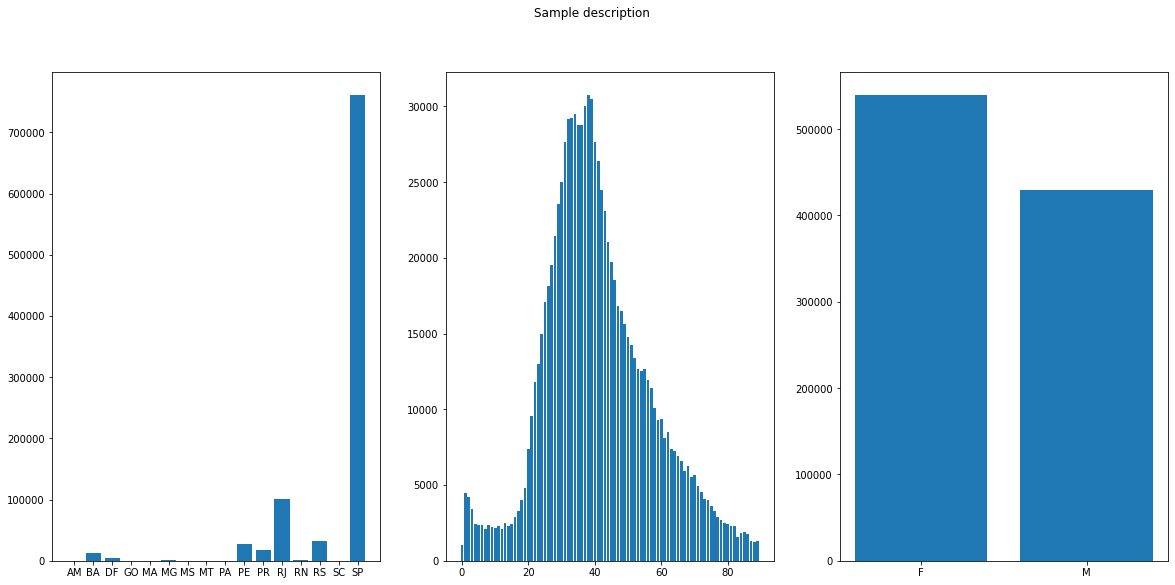

In [229]:
plt.figure(figsize=(20, 9))

plt.subplot(131)
x = subset_df(tbp,'CD_UF','tested')
plt.bar(x['CD_UF'], x['tested'])
plt.subplot(132)
x = subset_df(tbp,'IDADE','tested')
plt.bar(x['IDADE'], x['tested'])
plt.subplot(133)
x = subset_df(tbp,'IC_SEXO','tested')
plt.bar(x['IC_SEXO'], x['tested'])
plt.suptitle('Sample description')
plt.show()

In [116]:
dtyme = exames.groupby('DT_COLETA')['##positivo##', '##falso_positivo##',
       '##desconhecido##', '##negativo##', '##nova_coleta##',
       'tested'].apply(sum).reset_index()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [118]:
import datetime

In [127]:
dtyme['DT_COLETA'].apply(lambda x: str(x))

0      01/01/2020
1      01/02/2020
2      01/03/2020
3      01/04/2020
4      01/05/2020
          ...    
448    31/01/2020
449    31/03/2020
450    31/05/2020
451    31/07/2020
452    31/12/2019
Name: DT_COLETA, Length: 453, dtype: object

In [136]:
dtyme['DT_COLETA'] = pd.to_datetime(dtyme['DT_COLETA'].astype(str), format='%d/%m/%Y')

ValueError: time data '2020-02-26' does not match format '%d/%m/%Y' (match)

In [133]:
dtyme['DT_COLETA'].apply(lambda x: datetime.datetime.strptime(str(x), '%d/%m/%Y'))

ValueError: time data '2020-02-26' does not match format '%d/%m/%Y'

In [103]:
dtyme['DT_COLETA'] = pd.to_datetime(dtyme['DT_COLETA'], infer_datetime_format=True)

In [104]:
dtyme.sort_values('DT_COLETA', ascending=True, inplace=True)

In [132]:
dtyme['MONTH'] = dtyme['DT_COLETA'].apply(lambda x: x.month)

AttributeError: 'str' object has no attribute 'month'

In [115]:
dtyme

,DT_COLETA,##positivo##,##falso_positivo##,##desconhecido##,##negativo##,##nova_coleta##,tested,MONTH
8,2019-01-11,59,0,3,731,3,796,1
9,2019-01-12,5,0,0,99,1,105,1
18,2019-02-11,54,0,4,652,11,721,2
19,2019-02-12,38,0,1,505,1,545,2
28,2019-03-11,13,0,0,153,4,170,3
...,...,...,...,...,...,...,...,...
112,2020-12-03,213,0,2,4540,15,4770,12
113,2020-12-04,44,0,0,364,32,440,12
114,2020-12-05,828,2,40,3489,58,4415,12
115,2020-12-06,1231,1,215,8119,38,9603,12


In [113]:
dtyme.iloc[116]['DT_COLETA'].month

2

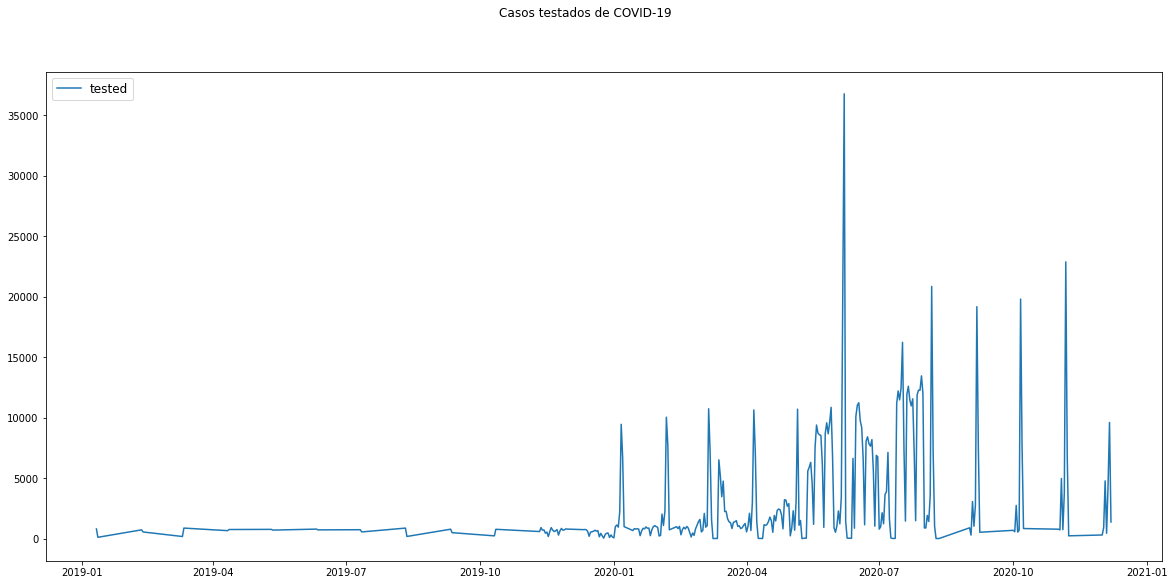

In [88]:
plt.figure(figsize=(20, 9))

xcols = ['DT_COLETA','tested']
x = subset_df(dtyme,xcols[0],xcols[1])
plt.plot(x[xcols[0]], x[xcols[1]], label=xcols[1], markersize=np.sqrt(20))
plt.suptitle('Casos testados de COVID-19')
plt.legend(loc="upper left", markerscale=20, fontsize=12)
plt.show()

In [73]:
dtyme.columns

Index(['DT_COLETA', '##positivo##', '##falso_positivo##', '##repetir##',
       '##desconhecido##', '##negativo##', '##nova_coleta##', 'tested'],
      dtype='object')

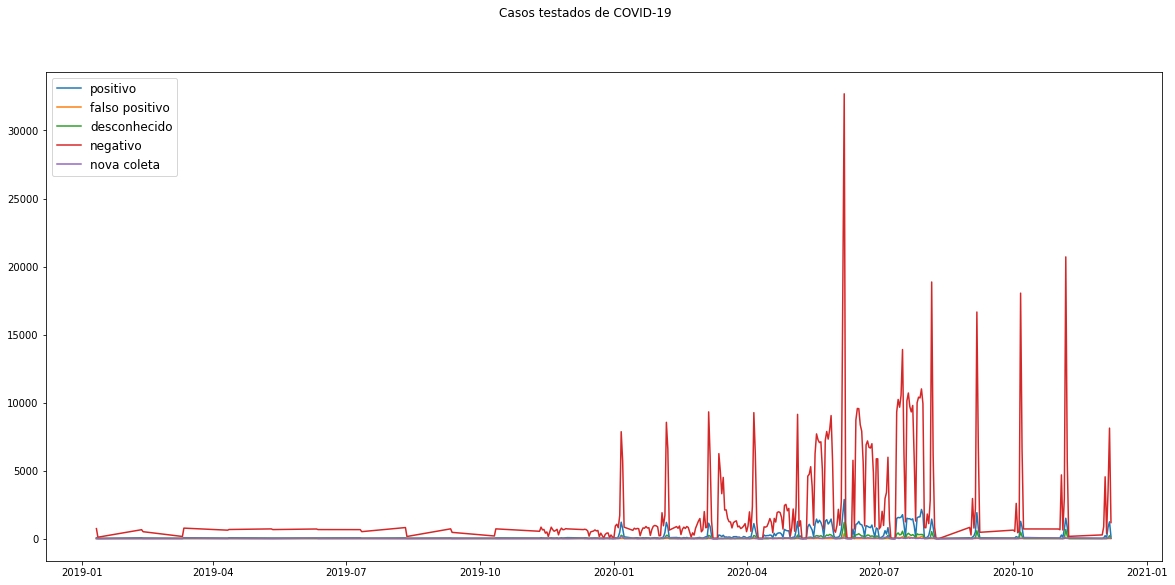

In [106]:
plt.figure(figsize=(20, 9))

for c in ['##positivo##', '##falso_positivo##', '##desconhecido##', '##negativo##', '##nova_coleta##']:
    xcols = ['DT_COLETA', c]
    x = subset_df(dtyme,xcols[0],xcols[1])
    plt.plot(x[xcols[0]], x[xcols[1]], label=xcols[1].replace('##','').replace('_',' '), markersize=np.sqrt(20))
    
plt.suptitle('Casos testados de COVID-19')
plt.legend(loc="upper left", markerscale=20, fontsize=12)

# Display a figure.
plt.show()

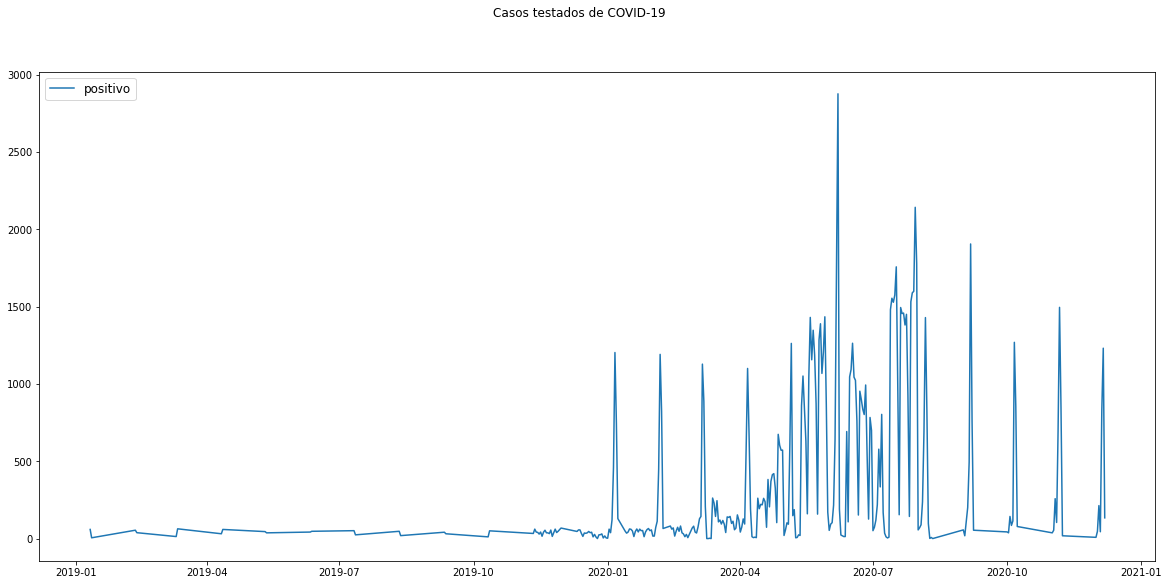

In [108]:
plt.figure(figsize=(20, 9))

for c in ['##positivo##']:
    xcols = ['DT_COLETA', c]
    x = subset_df(dtyme,xcols[0],xcols[1])
    plt.plot(x[xcols[0]], x[xcols[1]], label=xcols[1].replace('##','').replace('_',' '), markersize=np.sqrt(20))
    
plt.suptitle('Casos testados de COVID-19')
plt.legend(loc="upper left", markerscale=20, fontsize=12)

# Display a figure.
plt.show()

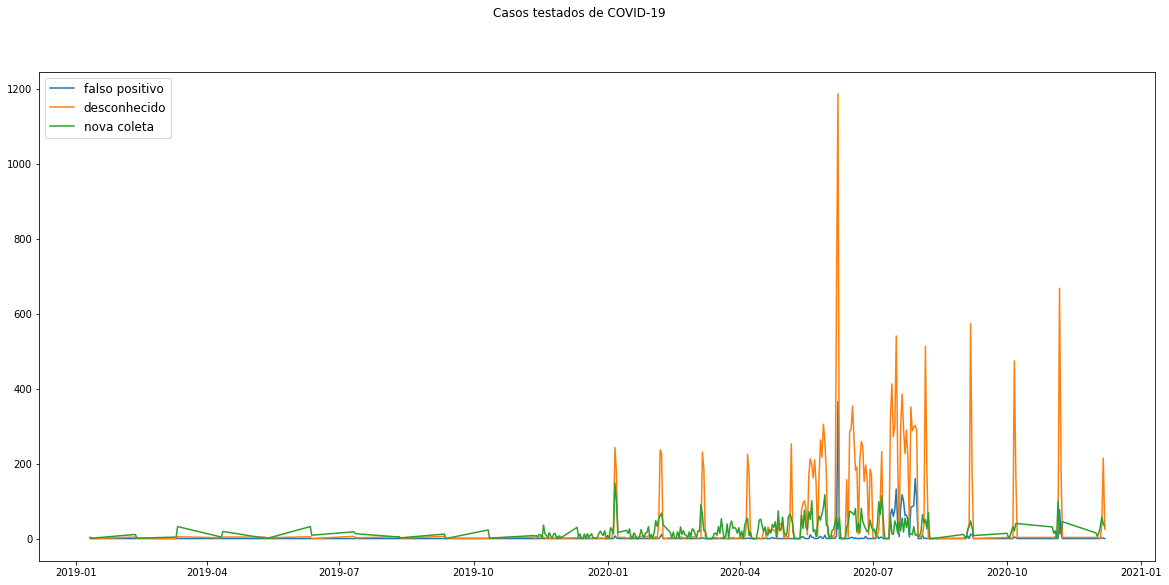

In [110]:
plt.figure(figsize=(20, 9))

for c in ['##falso_positivo##', '##desconhecido##', '##nova_coleta##']:
    xcols = ['DT_COLETA', c]
    x = subset_df(dtyme,xcols[0],xcols[1])
    plt.plot(x[xcols[0]], x[xcols[1]], label=xcols[1].replace('##','').replace('_',' '), markersize=np.sqrt(20))
    
plt.suptitle('Casos testados de COVID-19')
plt.legend(loc="upper left", markerscale=20, fontsize=12)

# Display a figure.
plt.show()

In [66]:
for target in replacements_values:
    print(f"{target}: {data[target].sum()}")

##positivo##: 108165
##nova_coleta##: 7200
##desconhecido##: 20014
##negativo##: 834284
##falso_positivo##: 2082
##repetir##: 126


Check how many testes were made in the dataset period

In [15]:
data.loc[data['DE_ANALITO'] == 'Resultado COVID-19:']['source'].unique()

array(['EINSTEIN'], dtype=object)

In [20]:
data.loc[data['source'] == 'GrupoFleury'].head(100)

,ID_PACIENTE,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,source,ID_ATENDIMENTO
0,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Detecção por PCR",NÃO DETECTADO,NaN,Não detectado,GrupoFleury,NaN
1,1AD07C7A1E4D80B608DD7A650766CCF0,19/03/2020,LAB,"NOVO CORONAVÍRUS 2019 (SARS-CoV-2), DETECÇÃO P...","Covid 19, Material",raspado de nasofaringe,NaN,NaN,GrupoFleury,NaN
2,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Hemoglobina,"15,2",g/dL,"13,5 a 17,5",GrupoFleury,NaN
3,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",VCM,"89,2",fL,"81,0 a 95,0",GrupoFleury,NaN
4,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Leucócitos,5940,/mm3,3.500 a 10.500,GrupoFleury,NaN
5,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Neutrófilos,3220,/mm3,1.700 a 7.000,GrupoFleury,NaN
6,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Eosinófilos,370,/mm3,50 a 500,GrupoFleury,NaN
7,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Basófilos,60,/mm3,0 a 300,GrupoFleury,NaN
8,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Linfócitos,1730,/mm3,900 a 2.900,GrupoFleury,NaN
9,7B10786D64F27D7732503D915A38DE6F,30/12/2019,LAB,"HEMOGRAMA, sangue total",Monócitos,560,/mm3,300 a 900,GrupoFleury,NaN


In [36]:
pd.set_option('display.max_rows', 500)